In [42]:
#imports
import numpy as np
import pandas as pd
import logging
log = logging.getLogger(__name__)
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal, stats #filters
import scipy.fftpack #fft


#        ABR DATA         #


In [43]:
#Reproducibility
np.random.seed(1)

#axis1 = mV
#axis2 = L/R
#axis3 = db
#axis4 = Hz
#axis5 = rat
freqs = [0, 2000, 4000, 8000, 16000, 24000, 32000]
dbs = [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25]

df_all = pd.DataFrame({'ratname':[],'frequency':[],'dB':[],'L/R':[],'ABR':[], 'filtered':[], 'label':[]})
for rat in ["R144863_090921", "R144883_091321", "R144884_091321", "R165176_04102022", "R165181_041322", "R165182_042022", "R165183_042022", "R165184_042222", "R165185_042222"]:
   
    i = 0
    for f in (freqs):
        i = str(i)
        folder = "data_text_files/"
        path = folder + rat + "/"
        file = path + i +'.txt'
        fh = open(file, "r")
        line = 0
        while True:
            if fh.readline().startswith('Data Pnt:'):
                break
            line += 1
        df = pd.io.parsers.read_csv(file, skiprows=line)
        #Keeping only the column containing the average 
        df = df[[c for c in df.columns if c.startswith('Average(uV):')]]
        df.columns = np.arange(len(df.columns))

       
        # # check index for number of left and right entries????
        fh = open(file, "r")
        line = 0
        while True:
            if fh.readline().startswith('Intensity:'):
                break
            line += 1
        db = (pd.io.parsers.read_csv(file, skiprows = line-1, header=None))[1:2].dropna(axis = 1)
        db1 = np.array(db)[:,1:].astype('int')

        d=0
        while True:
            if db1[:,d] >= 25:
                new_entry = {'ratname':rat,'frequency':f,'dB':db1[:,d],'L/R':'L','ABR':df.loc[:,d].to_numpy()}
                df_all = df_all.append(new_entry, ignore_index=True)
                d += 1
            if (db1[:,d] - db1[:,d+1]) < 0:
                d += 1
                break
            

        while True:
            if db1[:,d] >= 25:
                new_entry = {'ratname':rat,'frequency':f,'dB':db1[:,d],'L/R':'R','ABR':df.loc[:,d].to_numpy()}
                df_all = df_all.append(new_entry, ignore_index=True)
            d += 1
            if db1[:,d] < 25:
                break

        samples = len(df)
        fs = 25.00
        N = fs /2
        n = np.linspace(0, N, num=samples)    
       

/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/1853013439.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(new_entry, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/1853013439.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(new_entry, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/1853013439.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(new_entry, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/1853013439.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

<function matplotlib.pyplot.show(close=None, block=None)>

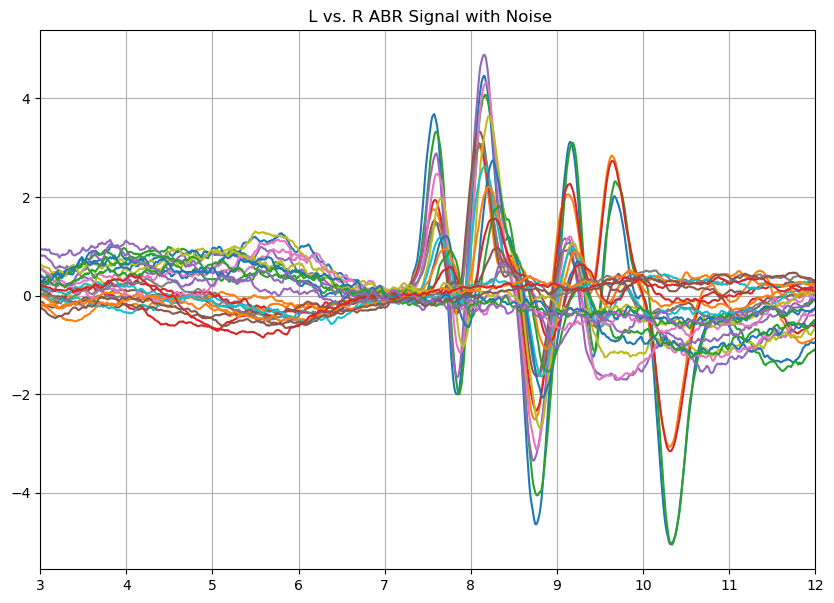

In [44]:
left = (df_all[df_all['L/R'] == "L"]["ABR"])
right = (df_all[df_all['L/R'] == "R"]["ABR"])



fig, ax = plt.subplots(1,1, figsize=(10,7))
i = 0
c = 0

plt.title(" L vs. R ABR Signal with Noise")
plt.grid()
plt.xlim(3,12)
plt.subplot(111)
for i in range(13):
    plt.plot(n, left[c+i])
    plt.plot(n, right[c+14+i])
plt.show

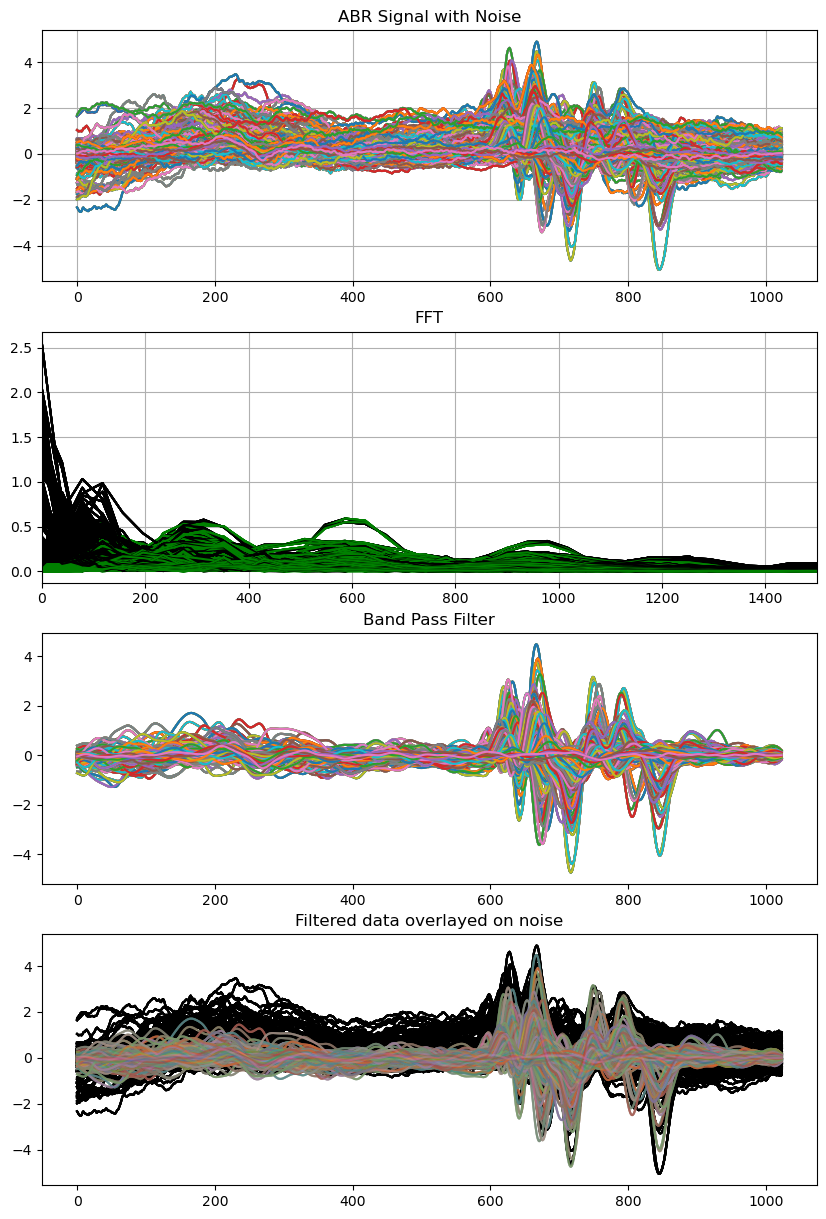

In [45]:
fs = 1/ .000025 #micro seconds
N = 1024 
T = 1.0 / fs 
nyquist = fs/2
x = np.linspace(0.0, N//fs, N)
xf = np.linspace(0.0, nyquist , N//2)


#create figure
fig, ax = plt.subplots(4, 1, figsize=(10,15))

r = 0
for r in range(len(df_all)):
    data = df_all.loc[r]["ABR"]


    plt.subplot(411)
    plt.plot(data)
    plt.title("ABR Signal with Noise")
    plt.grid()
    

    #fft
    yf = scipy.fftpack.fft(data)
    plt.subplot(412)
    plt.plot(xf, 2.0/N * np.abs(yf[0:samples//2]), color = 'black')
    plt.title("FFT")

    #bandstop
    b, a = scipy.signal.butter(3, [100/nyquist, 1500/nyquist], 'band')
    filteredBandPass = scipy.signal.filtfilt(b, a, data)
    plt.subplot(413)
    plt.plot( filteredBandPass)
    plt.title("Band Pass Filter")

     #fft
    yf = scipy.fftpack.fft(filteredBandPass)
    plt.subplot(412)
    plt.plot(xf, 2.0/N * np.abs(yf[0:samples//2]), color = 'green')
    plt.title("FFT")
    plt.grid()
    plt.xlim(0,1500)

    # #bandstop
    # b, a = scipy.signal.butter(3, [.02, .04], 'stop')
    # filteredBandPass = scipy.signal.filtfilt(b, a, data)
    # plt.subplot(414)
    # plt.plot(n, filteredBandPass)
    # plt.title("Band Pass Filter")


    #iterate
    r +=1



# #example abr wave form overlayed on noise
# j=0

# #noise data
for j in range(len(df_all)): 
    data = df_all.loc[j]["ABR"]
    plt.subplot(414)
    plt.plot( data, color = 'black', alpha = .75)
    j +=1

#filtered data
j=0
for j in range(len(df_all)): 
    data = df_all.loc[j]["ABR"]
    filteredBandPass = scipy.signal.filtfilt(b, a, data)
    plt.subplot(414)
    plt.plot(filteredBandPass, alpha = .3)
    plt.title("Filtered data overlayed on noise")
    j +=1

#show figure
plt.show()

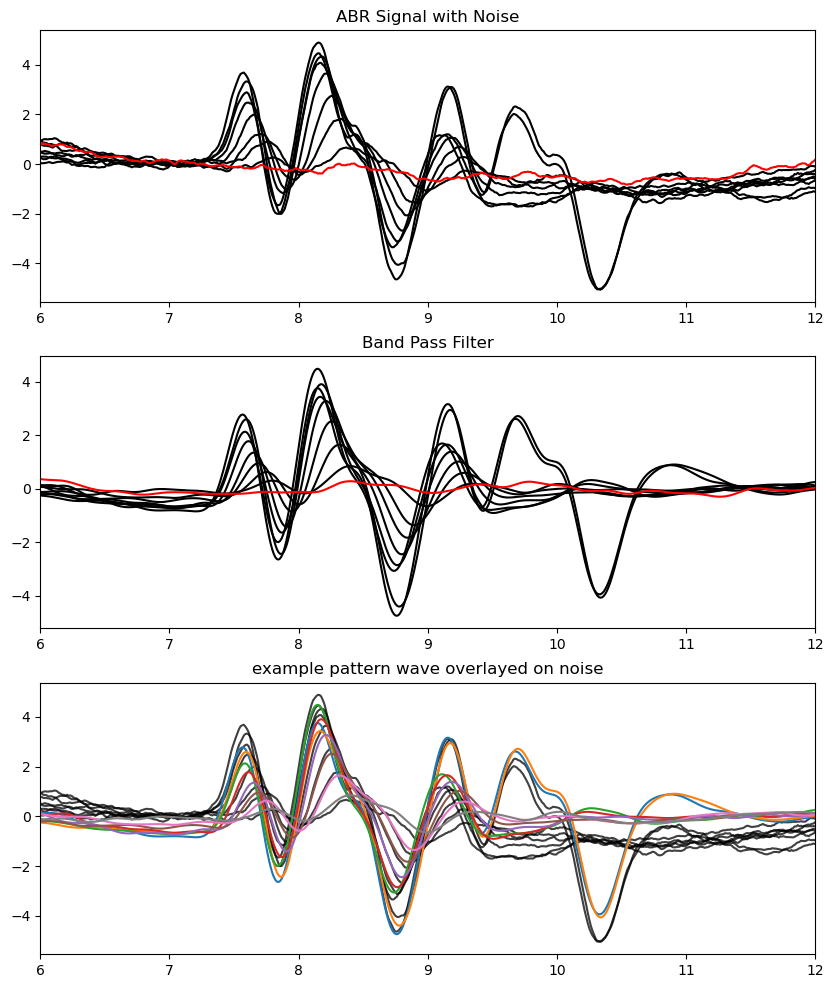

In [46]:
fs = 1/ .000025 #micro seconds
N = 1024 
T = 1.0 / fs 
nyquist = fs/2
x = np.linspace(0.0, N//fs, N)
xf = np.linspace(0.0, nyquist , N//2)


#create figure
fig, ax = plt.subplots(3, 1, figsize=(10,12))

i = 0
r = 0
for r in range(len(rat)):
    for i in range(28):
        data = df_all.loc[i]["ABR"]


        # plt.subplot(411)
        # plt.plot(n, data)
        # plt.title("ABR Signal with Noise")
        # plt.grid()
       

        # #fft
        # yf = scipy.fftpack.fft(data)
        # plt.subplot(412)
        # plt.plot(xf, 2.0/N * np.abs(yf[0:samples//2]))
        # plt.title("FFT")
        # plt.grid()
        # plt.xlim(0,1)

        #bandpass
        b, a = scipy.signal.butter(3, [100/nyquist, 1500/nyquist], 'band')
        filteredBandPass = scipy.signal.filtfilt(b, a, data)
        # # plt.subplot(413)
        # # plt.plot(n, filteredBandPass)
        # # plt.title("Band Pass Filter")
        # plt.margins(0, .05)


        #iterate
        i += 0
    r +=1



# #example abr wave form overlayed on noise
# j=0

threshold = 8 #exmple for threshold 

# #noise data
for j in range(14): 
    data = df_all.loc[j]["ABR"]

    plt.subplot(311)
    if j != threshold: 
        plt.plot(n, data, 'black')
    if j == threshold:
        plt.plot(n, data, 'red')
        break
    plt.title("ABR Signal with Noise")
    plt.grid()
    plt.xlim(6,12)


    plt.subplot(313)
    plt.plot(n, data, color = 'black', alpha = .75)
    plt.xlim(6,12)
    j +=1



#filtered data
j=0
for j in range(14): 
    data = df_all.loc[j]["ABR"]
    filteredBandPass = scipy.signal.filtfilt(b, a, data)

    plt.subplot(312)
    if j != threshold: 
        plt.plot(n, filteredBandPass, 'black')
    if j == threshold:
        plt.plot(n, filteredBandPass, 'red')
        break
    plt.title("Band Pass Filter")
    plt.margins(0, .05)
    plt.xlim(6,12)




    plt.subplot(313)
    plt.plot(n,filteredBandPass)
    plt.title("example pattern wave overlayed on noise")
    plt.xlim(6,12)
    j +=1


#show figure
plt.show()



In [47]:
### Tune with Machine Learning?

In [48]:
labels = np.ones(len(df_all))

dbs = [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25]
thresholds = [50, 50, 50, 50, 40, 40,40, 40, 35, 35, 25, 25, 20, 20, 
              45, 55, 45, 55, 40, 35, 40, 45, 40, 40, 20, 25, 30, 25,
               50, 45, 50, 50, 45, 45, 45, 45, 35, 40, 30, 30, 25, 20 ]

i = 0
for t in thresholds:
    for d in dbs:
        if d < t:
            labels[i] = 0
        i +=1
df_all['label'] = labels


In [49]:
fs = 1/ .000025 #micro seconds
N = 1024 
T = 1.0 / fs 
nyquist = fs/2
x = np.linspace(0.0, N//fs, N)
xf = np.linspace(0.0, nyquist , N//2)

#filtered data
j=0
filtered = pd.DataFrame({'data':[]})
for j in range(len(df_all)): 
    data = df_all.loc[j]["ABR"]
    b, a = scipy.signal.butter(3, [100/nyquist, 1500/nyquist], 'band')
    filt = scipy.signal.filtfilt(b, a, data)
    new_data = {'data':[filt]}
    filtered = filtered.append(new_data, ignore_index=True)


df_all['filtered'] = filtered


/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/4012689414.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered = filtered.append(new_data, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/4012689414.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered = filtered.append(new_data, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/4012689414.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered = filtered.append(new_data, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_12148/4012689414.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

9


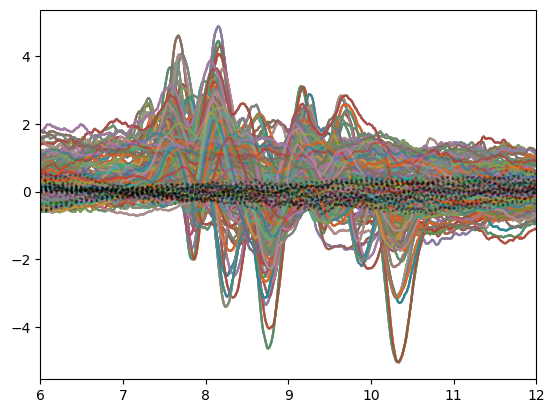

In [50]:
i = 0
signal = (df_all[df_all['label'] == 1]['ABR'])
for i in signal.index:
    plot =  np.array(signal[i]).transpose()
    plt.plot(n, plot, alpha = .5)
    plt.xlim(6,12)

i = 0
neg = (df_all[df_all['label'] == 0]['ABR'])
print(neg.index[0])
for i in neg.index:
    plot =  np.array(neg[i]).transpose()
    plt.plot(n, plot, ':', color = 'black', alpha = .1)
    plt.xlim(6,12)




9


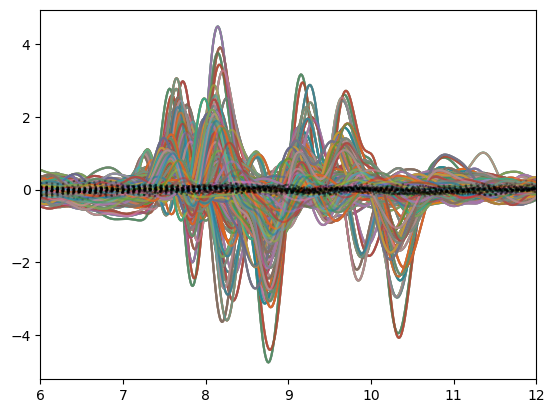

In [51]:
i = 0
signal = (df_all[df_all['label'] == 1]['filtered'])
for i in signal.index:
    plot =  np.array(df_all['filtered'][i]).transpose()
    plt.plot(n, plot, alpha = .5)
    plt.xlim(6,12)

i = 0
neg = (df_all[df_all['label'] == 0]['filtered'])
print(neg.index[0])
for i in neg.index:
    plot =  np.array(neg[i]).transpose()
    plt.plot(n, plot, ':', color = 'black', alpha = .1)
    plt.xlim(6,12)


#Maybe filter out for threshold using a maximum function??

In [52]:
#tested to ensure data drame accurately represents text files

df_all[585:]

,ratname,frequency,dB,L/R,ABR,filtered,label
585,R144884_091321,32000.0,[35],R,"[0.0752, 0.0582, 0.0572, 0.0334, 0.0284, 0.032...","[[-0.028208485073678808, -0.03159684864068831,...",1.0
586,R144884_091321,32000.0,[30],R,"[0.2491, 0.2533, 0.2501, 0.246, 0.2331, 0.2462...","[[0.031238110682514177, 0.03149567116155297, 0...",1.0
587,R144884_091321,32000.0,[25],R,"[-0.129, -0.1217, -0.1019, -0.0829, -0.0713, -...","[[-0.07694100249586575, -0.06728005078910469, ...",1.0
588,R165176_04102022,0.0,[90],L,"[-0.1355, -0.0839, -0.0687, -0.0695, -0.0919, ...","[[-0.1385283571733098, -0.14183165434290712, -...",1.0
589,R165176_04102022,0.0,[85],L,"[0.2907, 0.2635, 0.2694, 0.3058, 0.3254, 0.342...","[[0.022837164461342943, 0.029767795198231826, ...",1.0
...,...,...,...,...,...,...,...
1752,R165185_042222,32000.0,[45],R,"[0.3917, 0.385, 0.393, 0.3773, 0.3804, 0.3553,...","[[-0.007526065242117311, -0.01431569886170315,...",1.0
1753,R165185_042222,32000.0,[40],R,"[-0.0817, -0.0962, -0.09, -0.0839, -0.0647, -0...","[[-0.007739060500911653, -0.011091353575741725...",1.0
1754,R165185_042222,32000.0,[35],R,"[-0.114, -0.132, -0.1405, -0.1547, -0.1619, -0...","[[-0.012333738112288602, -0.02199870490986787,...",1.0
1755,R165185_042222,32000.0,[30],R,"[0.0769, 0.0954, 0.106, 0.1227, 0.1208, 0.1272...","[[-0.05610508311402883, -0.05514989656566295, ...",1.0


126
Int64Index([   0,   14,   28,   42,   56,   70,   84,   98,  112,  126,
            ...
            1617, 1631, 1645, 1659, 1673, 1687, 1701, 1715, 1729, 1743],
           dtype='int64', length=126)


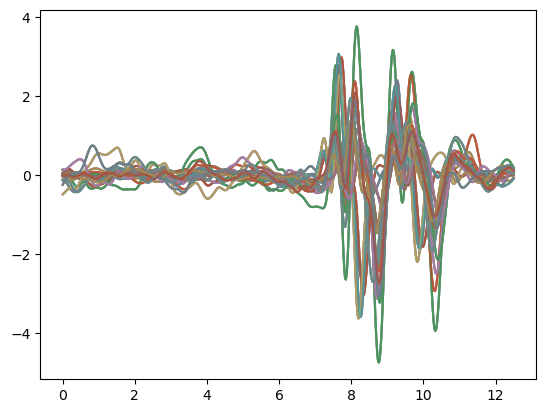

In [53]:
signal = (df_all[df_all['dB'] == 90]['filtered'])
i = 0
for i in signal.index:
    plot =  np.array(df_all['filtered'][i]).transpose()
    plt.plot(n, plot, alpha = .5)
    i += 1

print(len(signal))
print(signal.index)

filtered peaks
[ 11  61  97 140 169 201 226 327 367 394 418 450 524 544 575 620 662 690
 747 790 883 930]
unfiltered peaks
[   6   10   13   34   38   40   44   48   53   58   60   63   66   70
   73   75   81   95  114  116  120  123  126  128  135  137  140  145
  149  152  162  169  175  182  184  186  188  190  199  206  212  216
  219  223  230  238  247  249  265  268  271  273  275  281  301  309
  316  322  326  337  340  343  345  352  363  365  369  376  381  383
  389  394  398  406  410  412  418  424  428  435  439  444  449  454
  456  465  472  475  481  483  489  497  499  501  507  510  512  516
  520  525  540  547  550  560  568  571  576  579  582  585  619  662
  685  691  747  789  885  903  930  969  976  993  999 1003 1005 1016
 1021]


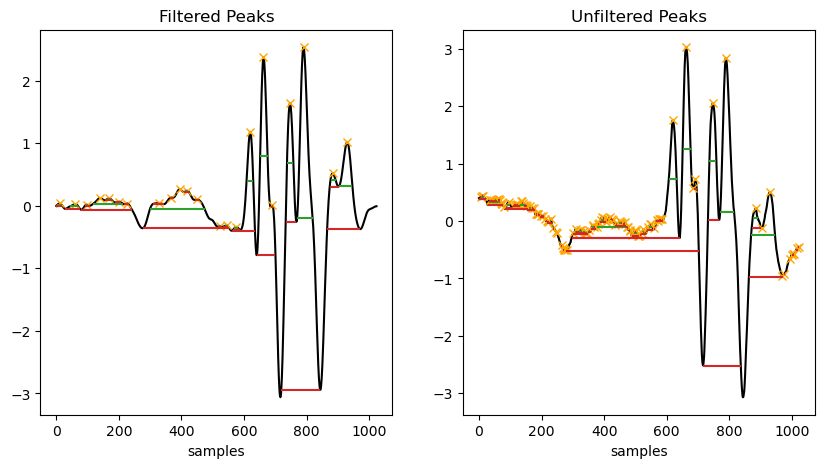

In [54]:
#expiramenting with find peaks algorithm
from scipy.signal import chirp, find_peaks, peak_widths

fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Generate example filtered ABR data
filt_data = df_all['filtered'].iloc[70]
filt_data = np.array(filt_data)[0,:]
plt.subplot(121)
plt.plot(filt_data, color = 'black')
peaks, _ = find_peaks(filt_data)
# valleys, _ = 
print("filtered peaks")
print(peaks)

plt.plot(peaks, filt_data[peaks], "x", color = 'orange')
results_half = peak_widths(filt_data, peaks, rel_height=0.5)
results_full = peak_widths(filt_data, peaks, rel_height=1)
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.xlabel("samples")
plt.title("Filtered Peaks")


#Unfiltered data
data = (df_all['ABR'][70])
plt.subplot(122)
plt.plot(data, color = 'black')
peaks, _ = find_peaks(data)
print("unfiltered peaks")
print(peaks)
plt.subplot(122)
plt.plot(peaks, data[peaks], "x", color = 'orange')
results_half = peak_widths(data, peaks, rel_height=0.5)
results_full = peak_widths(data, peaks, rel_height=1)
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.xlabel("samples")
plt.title("Unfiltered Peaks")
plt.show()


wave 1 latency:
0.8919843597262949
wave 1 max peak:
1.7414

wave 2 latency:
1.4051808406647108
wave 2 max peak:
3.0289

wave 5 latency:
4.679863147605083
wave 5 max peak:
0.5031


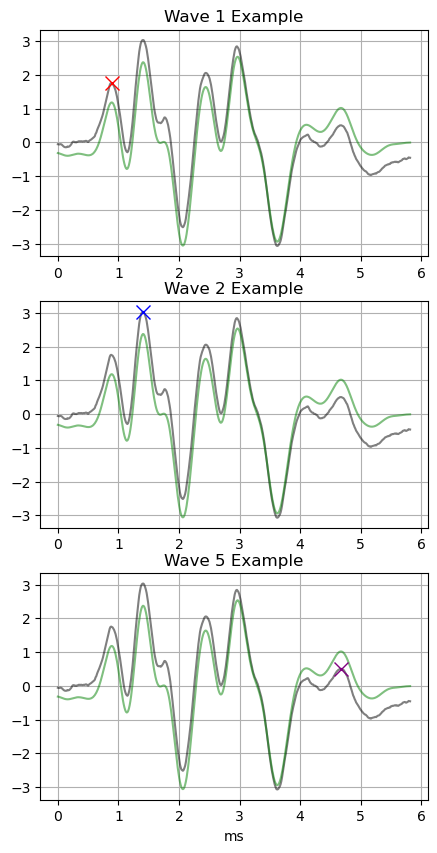

In [55]:


#*********** note sero position   ***********


z_pos = 548 -1
data = (df_all['ABR'][70][z_pos:])
filt_data = filt_data[z_pos:]
fig, ax = plt.subplots(3, 1, figsize=(5,10))



#wave 1
wave_one_peak = 620 #hand selected from data "n" sampled points
latency = (n[wave_one_peak] - n[z_pos])
point = (latency, data[wave_one_peak-z_pos])
x, y = point
print("wave 1 latency:")
print(x)
print("wave 1 max peak:")
print(y)


plt.subplot(311)
plt.plot((n[z_pos:]-n[z_pos]), data, color = 'black', alpha = .5)
plt.plot((n[z_pos:]-n[z_pos]), filt_data, color = 'green', alpha = .5)
plt.plot(x, y, marker="x", markersize=10, markeredgecolor="red")
plt.title("Wave 1 Example")
plt.grid()






#wave 2
wave_one_peak = 662 #hand selected from data "n" sampled points
latency = (n[wave_one_peak] - n[z_pos])
point = (latency, data[wave_one_peak-z_pos])
x, y = point
print(

)
print("wave 2 latency:")
print(x)
print("wave 2 max peak:")
print(y)


plt.subplot(312)
plt.plot((n[z_pos:]-n[z_pos]), data, color = 'black', alpha = .5)
plt.plot((n[z_pos:]-n[z_pos]), filt_data, color = 'green', alpha = .5)
plt.plot(x, y, marker="x", markersize=10, markeredgecolor="blue")
plt.title("Wave 2 Example")
plt.grid()





#wave 5
wave_one_peak = 930 #hand selected from data "n" sampled points
latency = (n[wave_one_peak] - n[z_pos])
point = (latency, data[wave_one_peak-z_pos])
x, y = point
print(

)
print("wave 5 latency:")
print(x)

print("wave 5 max peak:")
print(y)

plt.subplot(313)
plt.plot((n[z_pos:]-n[z_pos]), data, color = 'black', alpha = .5)
plt.plot((n[z_pos:]-n[z_pos]), filt_data, color = 'green', alpha = .5)
plt.plot(x, y, marker="x", markersize=10, markeredgecolor="purple")
plt.title("Wave 5 Example")
plt.grid()


plt.xlabel("ms")
plt.show()



#Automate with find metrics related to peak width or sorted maximums??


filtered peaks
[  50  120  147  216  380  411  459  621  667  746  840  938  983 1013]


wave 1 max peak:
2.1305565399954314

wave 1 node height:
-0.7295065694587146

wave 1 amplitude:
2.860063109454146

wave 1 latency:
0.9042033235581624


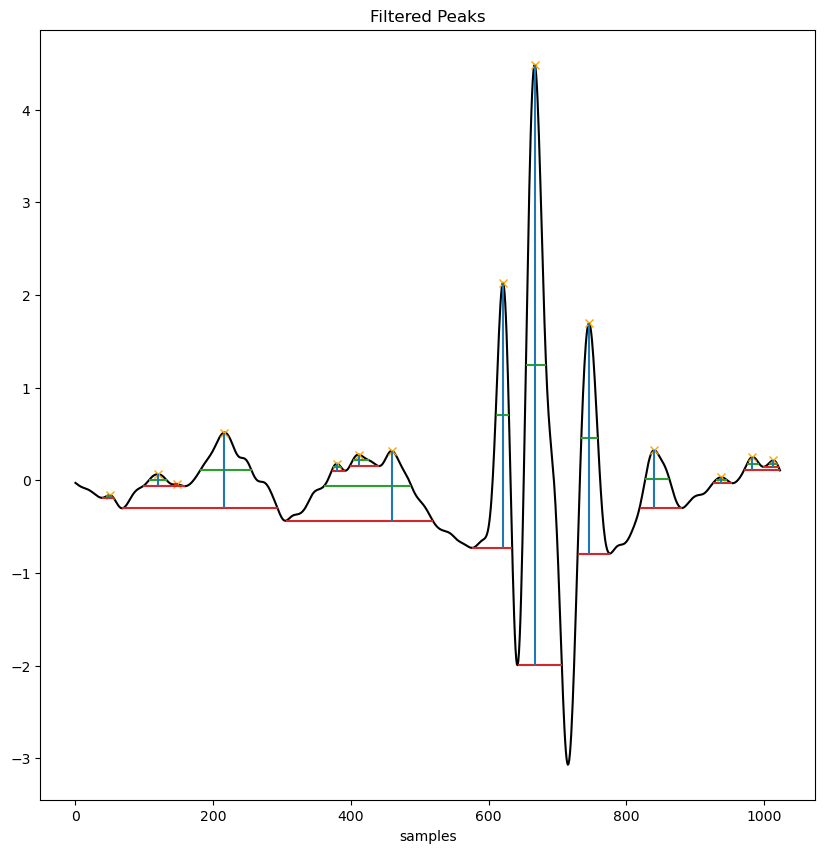

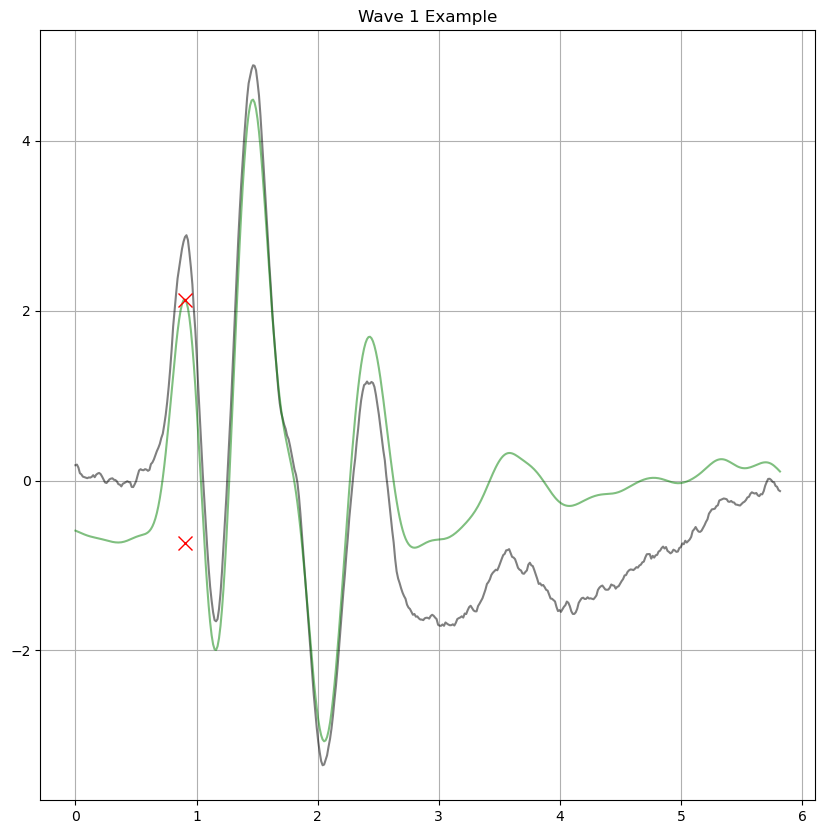

In [57]:

from scipy.signal import find_peaks, peak_prominences

#*********** note sero position   ***********



#expiramenting with find peaks algorithm
from scipy.signal import chirp, find_peaks, peak_widths

fig, ax = plt.subplots(1, 1, figsize=(10,10))

i = 58

# Generate example filtered ABR data
filt_data = df_all['filtered'].iloc[i]
filt_data = np.array(filt_data)[0,:]
plt.subplot(111)
plt.plot(filt_data, color = 'black')
peaks, _ = find_peaks(filt_data)
# valleys, _ = 
print("filtered peaks")
print(peaks)

plt.plot(peaks, filt_data[peaks], "x", color = 'orange')
results_half = peak_widths(filt_data, peaks, rel_height=0.5)
results_full = peak_widths(filt_data, peaks, rel_height=1)
prominences = peak_prominences(filt_data, peaks)[0] #add window length to speed up calculation
nodes = filt_data[peaks] - prominences
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.vlines(x=peaks, ymin=nodes, ymax=filt_data[peaks]) 
plt.xlabel("samples")
plt.title("Filtered Peaks")
print( )
print( )



# #Unfiltered data
# data = (df_all['ABR'][i])
# plt.subplot(122)
# plt.plot(data, color = 'black')
# peaks, _ = find_peaks(data)
# print("unfiltered peaks")
# print(peaks)
# plt.subplot(122)
# plt.plot(peaks, data[peaks], "x", color = 'orange')
# results_half = peak_widths(data, peaks, rel_height=0.5)
# results_full = peak_widths(data, peaks, rel_height=1)
# plt.hlines(*results_half[1:], color="C2")
# plt.hlines(*results_full[1:], color="C3")
# plt.xlabel("samples")
# plt.title("Unfiltered Peaks")
# plt.show()





z_pos = 548 -1
data = (df_all['ABR'][i][z_pos:])
filt_data = filt_data[z_pos:]
fig, ax = plt.subplots(1, 1, figsize=(10,10))



#wave 1
wave_one_peak = peaks[7] #hand selected from data "n" sampled points
#find wave one peak with sort algorithm
wave_one_node = nodes[7]

latency = (n[wave_one_peak] - n[z_pos])
point = (latency, filt_data[wave_one_peak-z_pos])
x, y = point
amp = y - wave_one_node





plt.subplot(111)
plt.plot((n[z_pos:]-n[z_pos]), data, color = 'black', alpha = .5)
plt.plot((n[z_pos:]-n[z_pos]), filt_data, color = 'green', alpha = .5)
plt.plot(x, y, marker="x", markersize=10, markeredgecolor="red")
plt.plot(x, wave_one_node, marker="x", markersize=10, markeredgecolor="red")
plt.title("Wave 1 Example")
plt.grid()



print("wave 1 max peak:")
print(y)
print()
print("wave 1 node height:")
print(wave_one_node)
print()
print("wave 1 amplitude:")
print(amp)
print()
print("wave 1 latency:")
print(x)


# Find the threshold point of ABR "wave 1" 
#The appearence or non appearence  of a significant peak 1 accross decreasing intesity (90->85--> .... --> 50 decibles) will help to determine the hearing threshold for the hearing test.

### Wave 1 is the first major peak of each waveform

### we will also want to the know the maximum (amplitude value) and latency (time value) of wave 1 for each wave
# Note
FILTERED RESPONSE LOSES MAXIMUM PEAK AMPLITUDE DATA
https://swharden.com/blog/2020-09-23-signal-filtering-in-python/



# Build a CNN for ABR Data Classification (3 classes)  - Pytorch


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as nnF
# from torch.utils.data import DataLoader as torch_dataloader
# from torch.utils.data import Dataset as torch_dataset
# import torch.optim as optim

## Load data and create dataloaders

In [ ]:
# X = df_all["filtered"]
# Y=  labels
# X= X.values
# X.shape


In [ ]:
# print(Y)
# print(Y.shape)

In [ ]:
# class MyDataset(torch_dataset):
#     def __init__(self, X, Y):
#         self.X=X
#         self.Y=Y
#     def __len__(self):        
#         return self.X.shape[0]
#     def __getitem__(self, idx):        
#         #we can use DatasetName[idx] to get a data point (x,y) with index idx
#         x=torch.tensor(self.X[idx], dtype=torch.float32)
#         y=torch.tensor(self.Y[idx], dtype=torch.int64)
#         x=x.reshape(1,-1)
#         return x, y

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [ ]:
# dataset_train=MyDataset(X_train, Y_train)
# dataset_val=MyDataset(X_val, Y_val)
# dataset_test=MyDataset(X_test, Y_test)

In [ ]:
# loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
# loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
# loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

In [ ]:
# print(X.shape)
# print(Y.shape)
# print(X_train.shape)
# print(Y_train.shape)

## The Neural Network: CNN

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=30, 
#                                kernel_size=5, stride=1, padding=2)        
#         self.conv2 = nn.Conv1d(30,15,5,1,2)        
#         self.conv3 = nn.Conv1d(15,5,5,1,2)       
#         self.fc1 = nn.Linear(640, 50)
#         self.fc2 = nn.Linear(50, 2)
#         #self.norm3 = nn.BatchNorm1d(64)
#         #self.norm4 = nn.BatchNorm1d(64)
#         #self.norm5 = nn.BatchNorm1d(64)     
#         self.max1=torch.nn.MaxPool1d(kernel_size=2,stride=2)
#         self.max2=torch.nn.MaxPool1d(kernel_size=2,stride=2)
#         self.max3=torch.nn.MaxPool1d(kernel_size=2,stride=2)
        
#     def forward(self, x):
#         #print("x", x.shape)
#         x1=nnF.relu(self.conv1(x))
#         #print("x1", x1.shape)
#         x2=self.max1(x1)
#         #print("x2", x2.shape)
#         x3=nnF.relu(self.conv2(x2))
#         #print("x3", x3.shape)
#         x4=self.max2(x3)
#         #print("x4", x4.shape)  
#         x5=nnF.relu(self.conv3(x4))
#         #print("x5", x5.shape)
#         x6=self.max3(x5)
#         #print("x6", x6.shape)
#         x7=x6.view(x6.shape[0], -1)
#         #print("x7", x7.shape)
#         x8=nnF.relu(self.fc1(x7))
#         #print("x8", x8.shape)
#         z=nnF.relu(self.fc2(x8))
#         #print(z.shape)
#         y=nnF.softmax(z, dim=1)        
#         return z

In [ ]:
# #debug your network here
# #make sure it works for one single input sample
# model=Net()
# x=torch.rand(1,1,1024) 
# z=model(x)

In [ ]:
# def save_checkpoint(filename, model, optimizer, result, epoch):
#     torch.save({'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'result':result},
#                filename)
#     print('saved:', filename)

In [ ]:
# def cal_accuracy(confusion):
#     #input: confusion is the confusion matrix
#     #output: acc is the standard classification accuracy
#     M=confusion.copy().astype('float32')
#     acc = M.diagonal().sum()/M.sum()    
#     sens=np.zeros(M.shape[0])
#     prec=np.zeros(M.shape[0]) 
#     for n in range(0, M.shape[0]):
#         TP=M[n,n]
#         FN=np.sum(M[n,:])-TP
#         FP=np.sum(M[:,n])-TP
#         sens[n]=TP/(TP+FN)
#         prec[n]=TP/(TP+FP)       
#     return acc, sens, prec

## The function to train the model

In [ ]:
# def train(model, device, optimizer, dataloader, epoch):    
#     model.train()#set model to training mode
#     loss_train=0
#     acc_train =0 
#     sample_count=0
#     for batch_idx, (X, Y) in enumerate(dataloader):
#         X, Y = X.to(device), Y.to(device)
#         optimizer.zero_grad()#clear grad of each parameter
#         Z = model(X)#forward pass
#         loss = nnF.cross_entropy(Z, Y)
#         loss.backward()#backward pass
#         optimizer.step()#update parameters
#         loss_train+=loss.item()
#         #do not need softmax
#         Yp = Z.data.max(dim=1)[1]  # get the index of the max               
#         acc_train+= torch.sum(Yp==Y).item()
#         sample_count+=X.size(0)
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
#                     epoch, 100. * batch_idx / len(dataloader), loss.item()))
#     loss_train/=len(dataloader)
#     #due to upsampling, len(dataloader.dataset) != sample_count
#     #acc_train/=len(dataloader.dataset) 
#     acc_train/=sample_count    
#     return loss_train, acc_train

## The Function to test the model

In [ ]:
# def test(model, device, dataloader):
#     model.eval()#set model to evaluation mode
#     acc_test =0
#     confusion=np.zeros((2,2))
#     with torch.no_grad(): # tell Pytorch not to build graph in the with section
#         for batch_idx, (X, Y) in enumerate(dataloader):
#             X, Y = X.to(device), Y.to(device)
#             Z = model(X)#forward pass
#             #do not need softmax
#             Yp = Z.data.max(dim=1)[1]  # get the index of the max 
#             acc_test+= torch.sum(Yp==Y).item()
#             for i in range(0, 2):
#                 for j in range(0, 2):
#                     confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
#     acc, sens, prec=cal_accuracy(confusion)
#     return acc, (confusion, sens, prec)

## Create a model, and start the traning-validation-testing process

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model=Net()
# model.to(device)
# x = dataset_train[0][0]
# z = model(x.view(1, 1, 1024))

In [ ]:
# y_hat=nnF.softmax(z, dim=1)
# y_hat

use stochastic gradient descent as the optimization method

In [ ]:
# optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# loss_train_list=[]
# acc_train_list=[]
# acc_val_list=[]
# epoch_save=-1

train/val/test over many epochs

In [ ]:
# for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
#     #-------- training --------------------------------
#     loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
#     loss_train_list.append(loss_train)
#     acc_train_list.append(acc_train)
#     print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
#     #-------- validation --------------------------------
#     acc_val, other_val = test(model, device, loader_val)
#     acc_val_list.append(acc_val)
#     print('epoch', epoch, 'validation acc:', acc_val)
#     #--------save model-------------------------
#     result = (loss_train_list, acc_train_list, 
#               acc_val_list, other_val)
#     save_checkpoint('Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
#     epoch_save=epoch

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(12,6))
# ax[0].set_title('loss v.s. epoch',fontsize=16)
# ax[0].plot(loss_train_list, '-b', label='training loss')
# ax[0].set_xlabel('epoch',fontsize=16)
# ax[0].legend(fontsize=16)
# ax[0].grid(True)
# ax[1].set_title('accuracy v.s. epoch',fontsize=16)
# ax[1].plot(acc_train_list, '-b', label='training accuracy')
# ax[1].plot(acc_val_list, '-g', label='validation accuracy')
# ax[1].set_xlabel('epoch',fontsize=16)
# ax[1].legend(fontsize=16)
# ax[1].grid(True)

load the best model

In [ ]:
# best_epoch=np.argmax(acc_val_list)
# best_epoch

In [ ]:
# checkpoint=torch.load('Pytorch_epoch'+str(best_epoch)+'.pt')
# model=Net()
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device);
# model.eval();

In [ ]:
# acc, (confusion, sens, prec) = test(model, device, loader_test)
# print('Sensitivity', sens)
# print('Precision', prec)
# print('Confusion \n', confusion)

In [ ]:
# print('Accuracy (average)', acc)

In [ ]:
# x = dataset_train[0][0]

# # Pass the input through the model
# with torch.no_grad():
#     x = x.view(1, 1, 1024)  # Reshape the input if needed
#     x = x.to(device)
#     output = model(x)
#     y_hat = nnF.softmax(output, dim=1)

# labels = ['label1', 'label2']  # Replace with your actual class labels
# probabilities = y_hat.squeeze().tolist()

# # Get the predicted class labels and probabilities
# labels = np.array(['label1', 'label2'])  # Replace with your actual class labels
# probabilities = y_hat.squeeze().cpu().numpy()

# # Print each label as an array
# for label, prob in zip(labels, probabilities):
#     label_array = np.array([label])
#     print("Label:", label_array)
#     print("Probabilities:", prob)
#     print()